<h1 align="center">Las N-reinas en un tablero ponderado</h1>
<h3 style="display:block; margin-top:5px;" align="center">(Ramificación y Poda)</h3>
<h3 style="display:block; margin-top:5px;" align="center">Algorítmica</h3>
<h3 style="display:block; margin-top:5px;" align="center">2021-2022</h3>    
<h3 style="display:block; margin-top:5px;" align="center">Universitat Politècnica de València</h3>
<br>

**Pon/poned aquí tú/vuestros nombre(s):**
- Manuel Díaz Pastor
- Luisa Mariana Ramirez Gómez

## Índice
1. ### [Descripción del problema](#introduccion)
1. ### [Actividad 1: Función de ramificación](#actividad1)
1. ### [Actividad 2: Cotas optimistas](#actividad2)
1. ### [Actividad 3: Comprobar que funciona](#actividad3)
1. ### [Actividad 4: Estudio experimental](#actividad4)


<a id='introduccion'></a>

<a id='actividad1'></a>

# Descripción del problema

## Las N-reinas en un tablero ponderado

En esta práctica de **dos sesiones** vamos a resolver mediante
ramificación y poda o *branch and bound* una variante del problema de
las $N$-reinas que ya hemos estudiado cuando vimos búsqueda con
retroceso o *backtracking*.

- En el problema **original** nuestro objetivo era situar $N$
  reinas en un tablero de $N \times N$ de modo que no se amenacen
  entre sí, sabiendo que cada reina se puede mover en horizontal,
  en vertical o en diagonal a cualquier distancia.

- En la variante con **tablero ponderado** vamos a suponer que cada
  casilla del tablero está etiquetada con un peso no negativo. El
  objetivo es encontrar la solución que, siendo válida en la variante
  original, **minimice la suma de pesos de las casillas ocupadas**.
  
Por tanto, la variante estudiada en esta práctica es claramente un
problema de **optimización**.

## Optimización vs satisfacción de restricciones

El problema original también es (trivialmente) un problema de
optimización si consideramos que el valor booleano cierto es mayor que
el falso. No obstante, en el problema original cualquier solución
factible es tan óptima como cualquier otra, cosa que no ocurre en
general en la nueva variante propuesta.


## Generación de instancias aleatorias

Vamos a utilizar `numpy` para generar una matriz de pesos aleatorios para un tablero de $N \times N$:

In [18]:
import numpy as np
def genera_instancia(N, low=0, high=1000):
    return np.random.randint(low=low,high=high,
                             size=(N,N),dtype=np.int)

Veamos un ejemplo con un tablero de 8x8 (como el del ajedrez):

In [14]:
test = genera_instancia(8)
test

array([[499, 779, 308, 709, 125, 793, 680, 422],
       [146, 384, 894, 715,   5, 138, 581, 501],
       [273, 411, 900, 452, 866, 690, 474, 289],
       [940, 931, 886, 799, 172,  46, 770, 378],
       [573, 715, 833, 572, 924, 471, 152, 403],
       [855, 339,  53, 571, 423, 201, 406, 754],
       [842, 510, 390, 121, 159, 105, 116, 252],
       [988, 445, 343, 951, 867, 946, 238, 229]])

### Representación de los estados

La formalización básica del problema ampliado es idéntico al problema
original: 

- Vamos a ir situando las reinas *columna por columna* de izquierda a derecha, de modo que una solución parcial será de la forma: $[s_0, s_1, \ldots, s_k]$
donde $s_i$ indica en qué fila (de $0$ a $N-1$) está la reina de la columna $i$-ésima (las columnas numeradas también de $0$ a $N-1$).

- El estado inicial será la lista vacía $[ \  ]$.

- Un estado $[s_0, s_1, \ldots, s_k]$ será terminal si $k == N-1$ o, equivalentemente, si `len(`$[s_0, s_1, \ldots, s_k]$`) == N`.

### Función para evaluar una solución

La siguiente función recibe una solución (dada como una lista Python con la fila a la que pertenece la reina de cada columna, *exactamente igual que en las N-reinas original*) y devuelve la suma de los pesos de las casillas ocupadas por las reinas:

In [19]:
def evaluate(s,weights):
    return sum(weights[row,col] for col,row in enumerate(s))

## Primera aproximación *casi* por fuerza bruta

En el código que se os proporciona hemos utilizado la versión de
búsqueda con retroceso o *backtracking* en la variante que encuentra
todas las soluciones. Cada vez que encuentra una solución la evalúa y se queda con la mejor hasta el momento.

A pesar de llamarse `bruteforce` no es la peor forma, hay formas de fuerza bruta más ineficientes. De todas formas, no aprovecha los valores del tablero durante la búsqueda, por lo que es de esperar que sea mejorable por otras aproximaciones, pero nos servirá para comparar:

In [20]:
def bruteforce(weights):
    bestSolution, bestScore = None, float("inf")
    def is_promising(s, newrow):
        newcol = len(s)
        return all(newrow != row and newcol-col != abs(newrow-row)
                   for col,row in enumerate(s))
    N = len(weights)
    def backtracking(s):
        nonlocal bestSolution, bestScore
        if len(s) == N:
            current = evaluate(s,weights)
            if current < bestScore:
                bestScore = current
                bestSolution = s
        else:
            for row in range(N):
                if is_promising(s, row):
                    backtracking(s+[row])
    backtracking([])
    return bestSolution, bestScore

Hagamos una prueba con un test pequeño:

In [10]:
smalltest = np.array([[38, 48, 39, 40],
                      [10, 24, 22, 10],
                      [34, 12, 43, 38],
                      [ 7, 12,  1, 40]]) 
bruteforce(smalltest)

([2, 0, 3, 1], 93)

## Cotas optimistas

La **cota optimista** es la suma de:

- La parte **conocida**, correspondiente a la suma de los pesos de las casillas donde ya se ha situado una reina (una reina por cada columna). Es similar a la parte de evaluar pero sumando únicamente las reinas ya situadas:

    ```
    sum(weights[row,col] for col,row in enumerate(s))
    ```

- La parte **por completar**, que se calcula como la suma de una estimación optimista de la mejor manera de colocar una reina en cada una de las columnas restantes. Podemos plantear varias aproximaciones:
      
  1. Tomar el mínimo de cada columna sin importar si esa casilla está amenazada o no (en el código se llama `optimisticSimple`).
  2. Considerar, para el mínimo, únicamente las filas *no amenazadas en horizontal*. Es decir, para cada una de las columnas donde todavía no hemos situado una reina, miramos el mínimo de las filas no elegidas ya por alguna reina ya situada en el tablero. Recuerda que, por construcción, no hay reinas amenazadas en la misma columna porque situamos una única reina por columna. Esta cota se denomina `optimisticHoriz`.  
  3. La cota `optimisticEllaborate` considera tanto las amenazas horizontales como las diagonales por parte de reinas ya situadas en el tablero hacia reinas en columnas donde todavía no hemos decidido. Como es posible que en alguna columna no quede ninguna fila sin amenazar, en ese caso devolveremos el valor `float('inf')`.


## Representación de los estados y del conjunto de estados activos

El conjunto de estados activos se representará mediante una cola de
prioridad implementada como un *heap*. Los elementos a guardar serán tuplas
donde el primer elemento será el valor de la cota
optimista y el segundo la lista Python que representa una solución
parcial.

El conjunto de estados activos será una cola de prioridad implementada mediante un *minheap*:

In [21]:
import heapq

El siguiente código ilustra las 2 funciones básicas para utilizar un `heapq` como cola de prioridad.

Observa que guardamos tuplas donde el primer campo es valor de la cota optimista de modo que se extrae el de menor cota (estamos en un problema de minimización).

In [22]:
A = [] # conjunto vacío de estados activos, es una lista Python normal y corriente
for score,s in [(10,[1]),(3,[2]),(100,[0,1])]:
    heapq.heappush(A,(score,s)) # insertar i en la cola de prioridad A
print(A) # no sale ordenado necesariamente, es un minheap...
while len(A)>0:
    score,s = heapq.heappop(A) # extraer el menor elemento de la cola de prioridad A
    print(score,s)

[(3, [2]), (10, [1]), (100, [0, 1])]
3 [2]
10 [1]
100 [0, 1]


## Esquema de ramificación y poda, funciones auxiliares

Podemos implementar el esquema de ramificación y poda o *branch and bound* básicamente como en los apuntes de teoría. En particular, las funciones auxiliares utilizadas son:

- `branch` recibe una solución parcial (un estado intermedio) y genera los estados hijo situando una reina en la siguiente columna. Debe evitar situar la nueva reina en aquellas filas que estén amenazadas por alguna de las reinas ya puestas en el tablero. Para realizar este código puedes inspirarte en el código de `is_promising` utilizado en la parte de backtracking.

- `is_complete` se limita a decir si una solución parcial es solución o estado terminal. Se proporciona ya implementada puesto que es tan fácil como ver si la longitud de la solución parcial es igual al nº columnas (lado del tablero o `N`).

- `optimisticSimple(s,weights, minWeights, parentCotaOpt)` calcula la cota optimista del estado `s`. Recibe la matriz de pesos del tablero, un vector con el menor peso de cada columna y la cota optimista del estado padre para poder realizar el cálculo de manera **incremental**.

- `optimisticHoriz(s, weights, minWeights, parentCotaOpt)` calcula la cota optimsita de `s` teniendo en cuenta la mejor forma de llenar las columnas resultantes utilizando las filas que no hayan sido ocupadas ya por alguna reina cuando ésta hace movimientos en horizonal. Este score NO se puede calcular de forma incremental, por lo que los argumentos `minWeights` y `parentCotaOpt` se pasan únicamente para poder llamar igual (homogéneramente) a los 3 tipos de cota optimista.

- `optimisticEllaborate(s, weights, minWeights, parentCotaOpt)` es parecida a la anterior pero ahora tiene en cuenta que las reinas ya situadas en el tablero también se podrían mover en diagonal. Tampoco se puede realizar de forma incremental.


El bucle principal de ramificación y poda es como sigue:


```python
    ...
    A = [] # empty priority queue
    x = None
    fx = float('inf')
    while len(A)>0 and A[0][0] < fx:
        s_cotaOpt, s = heapq.heappop(A)
        for child in branch(s,N):
            if is_complete(child): # si es terminal
                # es factible (pq branch solo genera factibles)
                # falta ver si mejora la mejor solucion en curso
                child_score = evaluate(child,weights)
                if child_score < fx:
                    fx, x = child_score, child
            else: # no es terminal
                # lo metemos en el cjt de estados activos si supera
                # la poda por cota optimista:
                child_cotaOpt = optimistic(child,weights,minWeights,s_cotaOpt)
                if child_cotaOpt < fx:
                    heapq.heappush(A, (child_cotaOpt, child) )
    return x,fx
```

Observa que utiliza la *poda implícita*.

A continuación mostramos las actividades a realizar y posteriormente el código donde hay que implementar o codificar esas actividades.

<a id='actividad1'></a>

# Actividad 1: función de ramificación.

Como ya se ha mencionado, ramificar es bastante sencillo porque la idea básica aparece en la función `is_promising` de backtracking.

La función puede utilizar `yield` para ir devolviendo las soluciones una por una o bien puede calcularlas todas y devolver una lista con todas ellas.

**Nota:** En este ejercicio y en los siguientes puedes utilizar los conjuntos Python (clase `set`) para ayudar en los cálculos. Utilizarlo es opcional, pero si se quiere utilizar una opción es definir un conjunto para guardar posiciones amenazadas en la diagonal y en la diagonal principal utilizando este esquema:

```python
# la diagonal ppal:
#     c0 c1 c2 c3]
#    -------------
# r0 | 0| 1| 2| 3|
#    -------------
# r1 |-1| 0| 1| 2|
#    -------------
# r2 |-2|-1| 0| 1|
#    -------------
# r3 |-3|-2|-1| 0|
#    -------------
# esto se consigue para [r,c] con el valor c-r

# la diagonal inversa:
#     c0 c1 c2 c3
#    -------------
# r0 |-3|-2|-1|0 |
#    -------------
# r1 |-2|-1| 0| 1|
#    -------------
# r2 |-1| 0| 1| 2|
#    -------------
# r3 | 0| 1| 2| 3|
#    -------------
# se consigue con r+c-(N-1)

```

Para ello se crean los conjuntos:

```python
diag    = set()
diaginv = set()
```
y se rellenan con un recorrido por la parte conocida del estado. Después se utilizan estos conjuntos para comprobar si las diagonales que nos interesan están libres o no. La alternativa es comprobarlo con un bucle anidado ¿qué coste tendría cada opción?

Puedes completar aquí la función (es una función independiente, no es un método de ninguna clase ni una clausura (función local dentro de otra):

In [155]:
'''N = 8
diag = [None] * N * N
for i in range(0,N):
    for j in range(0,N):
        diag[N*j + i] = i - j

diag    = diag
diaginv = set()'''
a = [4,6,1]
print(a)
n = 10
print(n)
def printea(col, newcol):
    print(col)
    print(newcol)
    return True
def branch(s, N): # N es el lado del tablero
    # COMPLETAR
    newcol = len(s)
    if len(s) < N:
        for newrow in range(N):
            if all(newrow != row and newcol-col != abs(newrow-row) for col,row in enumerate(s)):
                aux = s + [newrow]
                yield aux

[4, 6, 1]
10


<a id='actividad2'></a>

# Actividad 2: Cotas optimistas.

Se trata de implementar las 3 cotas optimistas descritas más arriba.

El tipo de cota optimista se especifica en la llamada principal y, en función del tipo elegido, se guarda una referencia a la función correspondiente en la variable `optimistic`. Es por ese motivo que las 2 últimas funciones reciben argumentos que realmente no les hacen falta pero que sí convienen a la primera de las cotas.


In [156]:
def optimisticSimple(s, weights, minWeights, parentCotaOpt):
    # cálculo de manera incremental:
    # COMPLETAR:
    res = sum(weights[row,col] for col,row in enumerate(s))
    for i in range(len(s),len(minWeights)):
            res += minWeights[i]
    return res
    
def optimisticHoriz(s, weights, minWeights, parentCotaOpt):    
    N = weights.shape[0]
    # parte conocida:
    opt = sum(weights[row,col] for col,row in enumerate(s))
    # cota optimista de la parte que nos queda por completar:
    # COMPLETAR
    for i in range(len(s), N):
        for j in range(N):
            if weights[i,j] == minWeights[i]:
                if j in s:
                    opt += float('inf')
                else :
                    opt += minWeights[i]
    return opt    
                

def optimisticEllaborate(s, weights, minWeights, parentCotaOpt):
    # COMPLETAR
    N = weights.shape[0]
    # parte conocida:
    opt = sum(weights[row,col] for col,row in enumerate(s))
    # cota optimista de la parte que nos queda por completar:
    # COMPLETAR
    for i in range(len(s), N):
        for j in range(N):
            if weights[i,j] == minWeights[i]:
                if (j in s) or all(i-col != abs(j-row) for col,row in enumerate(s)):
                    opt += float('inf')
                else :
                    opt += minWeights[i]
    return opt    

<a id='actividad3'></a>

<a id='actividad3'></a>

# Actividad 3: Comprobar que funciona

El siguiente código hace uso de las funciones definidas anteriormente:

In [157]:
def branchAndBound(weights,
                   verbosity=0,
                   optimistic=optimisticSimple):

    # no haría falta pero por si acaso comprobamos que weights es una
    # matriz numpy cuadrada y de costes positivos
    assert(type(weights) is np.ndarray and len(weights.shape) == 2
           and weights.shape[0] == weights.shape[1] and weights.dtype == np.int
           and weights.min()>=0)
    
    N = weights.shape[0]

    def is_complete(s):
        return len(s)==N #conocida del est

    minWeights = [weights[:,col].min() for col in range(N)]
    A = [] # empty priority queue
    x = None
    fx = float("inf") # valor inicial peor que cualquier solución

    # anyadimos el estado inicial:
    s = []
    # calculamos el score del estado inicial "[]" de forma no
    # incremental. Basta con sumar los valores de minWeights
    opt = sum(minWeights)
    heapq.heappush(A,(opt,s))

    iterations = 0 # nº iteraciones
    gen_states = 0 # nº estados generados
    podas_opt  = 0 # nº podas por cota optimista
    maxA = 0 # tamaño máximo alzanzado por lista de estados activos
    # bucle principal de ramificacion y poda con PODA IMPLICITA
    while len(A)>0 and A[0][0] < fx:
        iterations += 1
        lenA = len(A)
        maxA = max(maxA,lenA)
        score_s,s = heapq.heappop(A)
        if verbosity > 1:
            print(f"Iter. %04d |A|={iterations:05} max|A|={lenA:05}"+
                  f" fx={fx:04} len(s)={len(s):02} score_s={score_s:04}") 
        for child in branch(s, N):
            gen_states += 1            
            if is_complete(child): # si es terminal
                # seguro que es factible
                # falta ver si mejora la mejor solucion en curso
                child_score = evaluate(child,weights)
                if child_score < fx:
                    if verbosity > 0:
                        print("MEJORAMOS",x,fx,"CON",child,child_score)
                    x, fx = child, child_score
            else: # no es terminal
                # la función optimistic recibe como 3er argumento
                # el score del padre para poder realizar el
                # cálculo de manera incremental:
                child_cotaOpt = optimistic(child,weights,minWeights,score_s)
                # lo metemos en el cjt de estados activos si supera
                # la poda por cota optimista:
                if child_cotaOpt < fx:
                    heapq.heappush(A,(child_cotaOpt,child))
                else:
                    podas_opt += 1
    if verbosity > 0:
        print(f"{iterations} iteraciones, max|A|={maxA}, "+
              f"estados_generados={gen_states}, tiposestados_podados={podas_opt}")
    return x,fx,{'iterations':iterations,'gen_states':gen_states,'podas_opt':podas_opt}

Para comprobar que funciona correctamente compararemos el resultado de la función `branchAndBound` y la de `bruteforce`:

In [158]:
test = np.array([
       [222, 573,  21, 640, 863, 592, 310, 291],
       [976, 692, 451, 379, 138, 653, 489, 776],
       [537, 463, 199, 517, 114, 323, 611, 674],
       [788, 700, 801, 556, 194, 188, 479, 230],
       [914, 353, 680,  85, 124, 100, 383, 212],
       [365,  67, 554, 672, 886, 817, 555,  50],
       [229, 666, 547, 189, 837, 577, 536, 905],
       [ 74, 659, 559,  72,  35, 689, 678, 494]])

In [159]:
bruteforce(test)

([7, 2, 0, 5, 1, 4, 6, 3], 2234)

In [160]:
branchAndBound(test)

([7, 2, 0, 5, 1, 4, 6, 3],
 2234,
 {'iterations': 485, 'gen_states': 816, 'podas_opt': 168})

Veamos que funciona con las otras dos cotas optimistas:

In [161]:
branchAndBound(test, optimistic=optimisticHoriz)

([7, 2, 0, 5, 1, 4, 6, 3],
 2234,
 {'iterations': 842, 'gen_states': 1257, 'podas_opt': 177})

In [162]:
branchAndBound(test, optimistic=optimisticEllaborate)

([7, 2, 0, 5, 1, 4, 6, 3],
 2234,
 {'iterations': 842, 'gen_states': 1257, 'podas_opt': 177})

Las 4 ejecuciones de arriba deben de dar el mismo score. Normalmente también dan el mismo posicionamiento de las reinas, pero recuerda que en problemas de optimización podría haber empates.

<a id='actividad4 '></a>

# Actividad 4. Estudio experimental

La última actividad consiste en comparar empíricamente las tres cotas.

Está claro que la versión `bruteforce` (backtracking enumerando **todas** las soluciones factibles para quedarnos con la mejor) explota rápidamente y no tiene interés, aun así no cuesta nada probarla hasta talla 12 (para talla 14 sube a más de 10 minutos).

La comparación de los 3 tipos de cota optimista permite ver cuál se comporta mejor. Dejamos como ejercicio que analices el resultado comparando los tiempos de ejecución y el número de estados generados y podados.


In [163]:
import time

In [169]:
for N in [8,9,10,11,12,13]:
    board = genera_instancia(N)
    t1 = time.process_time()
    sol1 = bruteforce(board)
    t2 = time.process_time()
    print(f'N={N:2} {t2-t1:6.2f}s')
    
# ATENCIÓN: en mi ordenador, una ejecución concreta ha dado:
# N= 8   0.02s
# N= 9   0.11s
# N=10   0.48s
# N=11   2.61s
# N=12  15.18s
# N=13  91.55s
# N=14 616.46s <- he estado a punto de pararlo :|
# dejamos N hasta 12, ejecuciones distintas pueden variar ligeramente en los tiempos....

N= 8   0.02s
N= 9   0.08s
N=10   0.40s
N=11   2.00s
N=12  11.70s
N=13  70.49s


In [167]:
tallas = [8,9,10,11,12,13,14,15,16] # si es muy lento elimina los valores más altos...

tipos_cota = (('simple',optimisticSimple),
                       ('horiz',optimisticHoriz),
                       ('ellaborate',optimisticEllaborate))

dic_time = {}
dic_iterations = {}
dic_gen_states = {}
dic_podas_opt = {}

for nombre,funcion in tipos_cota:
    dic_time[nombre] = []
    dic_iterations[nombre] = []
    dic_gen_states[nombre] = []
    dic_podas_opt[nombre] = []

# MUY IMPORTANTE usar el mismo tablero para las 3 cotas, por eso generamos un tablero
# y por eso el doble bucle se organiza así...
for N in tallas:
    board = genera_instancia(N)
    for nombre,funcion in tipos_cota:    
        t1 = time.process_time()
        x,fx,stats = branchAndBound(board,optimistic=funcion)
        t2 = time.process_time()
        print(f'N={N:2} {nombre:10} {t2-t1:6.2f}s')
        dic_time[nombre].append(t2-t1)
        dic_iterations[nombre].append(stats['iterations'])
        dic_gen_states[nombre].append(stats['gen_states'])
        dic_podas_opt[nombre].append(stats['podas_opt'])
        

N= 8 simple       0.01s
N= 8 horiz        0.01s
N= 8 ellaborate   0.01s
N= 9 simple       0.05s
N= 9 horiz        0.06s
N= 9 ellaborate   0.06s
N=10 simple       0.12s
N=10 horiz        0.24s
N=10 ellaborate   0.08s
N=11 simple       0.25s
N=11 horiz        1.16s
N=11 ellaborate   0.36s
N=12 simple       0.91s
N=12 horiz        1.22s
N=12 ellaborate   0.26s
N=13 simple       3.41s
N=13 horiz        3.93s
N=13 ellaborate   1.17s
N=14 simple      31.95s
N=14 horiz       63.16s
N=14 ellaborate  12.62s
N=15 simple      19.70s
N=15 horiz      126.99s
N=15 ellaborate 131.36s
N=16 simple       5.00s
N=16 horiz      194.03s
N=16 ellaborate 604.50s


In [170]:
import matplotlib.pyplot as plt

## Comparación de tiempos

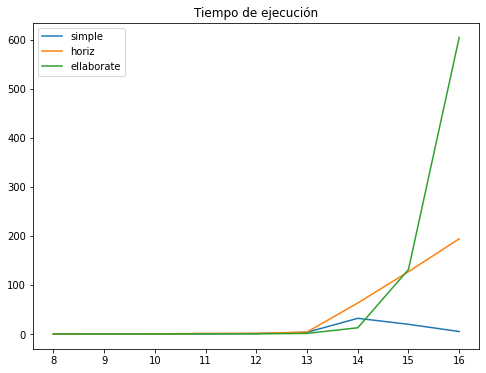

In [171]:
plt.figure(figsize=(8,6))
for nombre,funcion in tipos_cota:
    plt.plot(tallas, dic_time[nombre], label=nombre)
plt.legend(loc='upper left')
plt.title('Tiempo de ejecución')
plt.show()

# Número de iteraciones

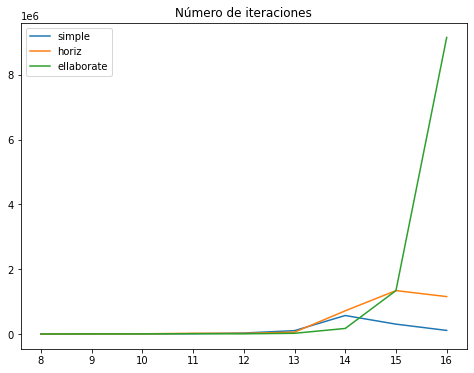

In [172]:
plt.figure(figsize=(8,6))

for nombre,funcion in tipos_cota:
    plt.plot(tallas, dic_iterations[nombre], label=nombre)
plt.legend(loc='upper left')
plt.title('Número de iteraciones')
plt.show()

## Número de estados generados

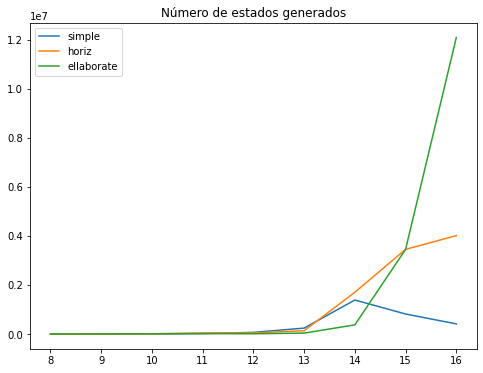

In [173]:
plt.figure(figsize=(8,6))

for nombre,funcion in tipos_cota:
    plt.plot(tallas, dic_gen_states[nombre], label=nombre)
plt.legend(loc='upper left')
plt.title('Número de estados generados')
plt.show()

## Número de estados podados

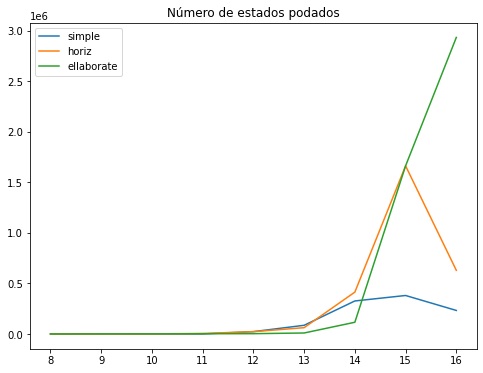

In [174]:
plt.figure(figsize=(8,6))

for nombre,funcion in tipos_cota:
    plt.plot(tallas, dic_podas_opt[nombre], label=nombre)
plt.legend(loc='upper left')
plt.title('Número de estados podados')
plt.show()

## Cuestión: ¿Qué se puede concluir de las gráficas anteriores?

Describe brevemente qué se puede concluir de los resultados anteriores, en particular 

- ¿Aumenta de manera monótona el tiempo de ejecución o hay instancias que son particularmente más difíciles que otras de talla mayor?
- Es más rápida una cota optimista que de lugar a un número menor de estados generados?


Podemos observar cómo, a medida que aumentan las dimensiones, la cota optimista simple se convierte en la más eficiente.

1- Mantiene un aumento relativamente constante, sin embargo, hay instancias de mayor talla para las que el tiempo de ejecución es menor, debido al orden de poda.
2- Esta afirmación no es correcta, pues es posible que el tiempo consumido por los cálculos realizados para una menor generación de estados supere el tiempo que llevaría procesar estos estados.